# Experiment

## Install Python dependencies

In [1]:
%pip install --upgrade pip
%pip install --upgrade tf2onnx
%pip install --upgrade tensorflow-cpu
%pip install onnxruntime
%pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 29.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 MB 135.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 230.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 278.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 322.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 261.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 248.0 MB/s et

Import the dependencies for the model training code:

In [2]:
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tf2onnx
import onnx
import pickle
from pathlib import Path
import os 
os.environ["KERAS_BACKEND"] = "tensorflow"   # "jax"

2024-04-11 07:42:28.753633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the CSV data

The CSV data that you use to train the model contains the following fields:

* **distancefromhome** - The distance from home where the transaction happened.
* **distancefromlast_transaction** - The distance from the last transaction that happened.
* **ratiotomedianpurchaseprice** - The ratio of purchased price compared to median purchase price.
* **repeat_retailer** - If it's from a retailer that already has been purchased from before.
* **used_chip** - If the credit card chip was used.
* **usedpinnumber** - If the PIN number was used.
* **online_order** - If it was an online order.
* **fraud** - If the transaction is fraudulent.

In [3]:
Data = pd.read_csv('data/card_transdata.csv')
Data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
# Set the input (X) and output (Y) data. 
# The only output data is whether it's fraudulent. All other fields are inputs to the model.

X = Data.drop(columns = ['repeat_retailer','distance_from_home', 'fraud'])
y = Data['fraud']

# Split the data into training and testing sets so you have something to test the trained model with.

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle = False)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)

# Scale the data to remove mean and have unit variance. The data will be between -1 and 1, which makes it a lot easier for the model to learn than random (and potentially large) values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global distribution of variables (which is influenced by the test set) into the training set.

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.values)

Path("artifact").mkdir(parents=True, exist_ok=True)
with open("artifact/test_data.pkl", "wb") as handle:
    pickle.dump((X_test, y_test), handle)
with open("artifact/scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)

# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones), set a class weight to weight the few fraudulent transactions higher than the many non-fraud transactions.

class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

## Build the model

The model is a simple, fully-connected, deep neural network, containing three hidden layers and one output layer.

In [5]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = len(X.columns)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

/opt/app-root/lib64/python3.9/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593 (10.13 KB)

 Trainable params: 2,465 (9.63 KB)

 Non-trainable params: 128 (512.00 B)

## Train the model

Training a model is often the most time-consuming part of the machine learning process.  Large models can take multiple GPUs for days.  Expect the training on CPU for this very simple model to take a minute or more.

In [6]:
# Train the model and get performance

epochs = 2
history = model.fit(X_train, y_train.ravel(), epochs=epochs, \
                    validation_data=(scaler.transform(X_val.values), y_val.ravel()), \
                    verbose=True, class_weight=class_weights)
print("Training of model is complete")

Epoch 1/2
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.9010 - loss: 0.2875 - val_accuracy: 0.9480 - val_loss: 0.2116
Epoch 2/2
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9476 - loss: 0.2356 - val_accuracy: 0.9473 - val_loss: 0.2203
Training of model is complete


## Save the model file

In [7]:
# Save the model as ONNX for easy use of ModelMesh
model.output_names=['output']

input_shape = len(X.columns)
input_signature = [tf.TensorSpec([None, input_shape], tf.float32, name='input')]

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)
os.makedirs("models/fraud", exist_ok=True)
# model.save('models/fraud/tf_model.keras')
onnx.save(model_proto, "models/fraud/model.onnx")

2024-04-11 07:43:36.930496: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-04-11 07:43:36.930617: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-04-11 07:43:36.988537: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-04-11 07:43:36.989037: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


## Confirm the model file was created successfully

The output should include the model name, size, and date. 

In [8]:
! ls -alRh ./models/

./models/:
total 12K
drwxr-sr-x.  3 1001150000 1001150000 4.0K Apr 11 07:43 .
drwxrwsr-x. 13 1001150000 1001150000 4.0K Apr 11 07:43 ..
drwxr-sr-x.  2 1001150000 1001150000 4.0K Apr 11 07:43 fraud

./models/fraud:
total 24K
drwxr-sr-x. 2 1001150000 1001150000 4.0K Apr 11 07:43 .
drwxr-sr-x. 3 1001150000 1001150000 4.0K Apr 11 07:43 ..
-rw-r--r--. 1 1001150000 1001150000  13K Apr 11 07:43 model.onnx


## Test the model

In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import onnxruntime as rt

Load the test data and scaler:

In [10]:
with open('artifact/scaler.pkl', 'rb') as handle:
    scaler = pickle.load(handle)
with open('artifact/test_data.pkl', 'rb') as handle:
    (X_test, y_test) = pickle.load(handle)

Create an ONNX inference runtime session and predict values for all test inputs:

In [12]:
sess = rt.InferenceSession("models/fraud/model.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
y_pred_temp = sess.run([output_name], {input_name: scaler.transform(X_test.values).astype(np.float32)}) 
y_pred_temp = np.asarray(np.squeeze(y_pred_temp[0]))
threshold = 0.995
y_pred = np.where(y_pred_temp > threshold, 1,0)

Show the results:

Accuracy: 0.96556


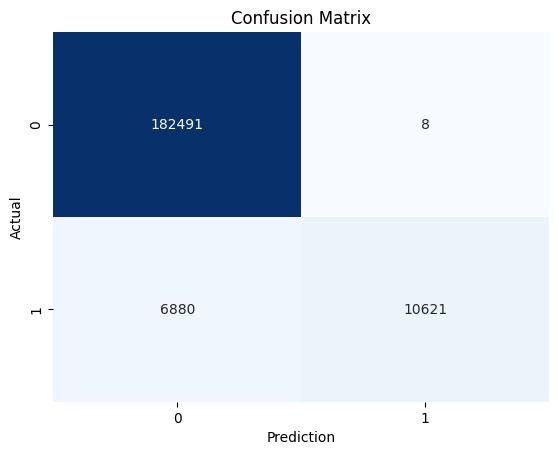

In [13]:
accuracy = np.sum(np.asarray(y_test) == y_pred) / len(y_pred)
print("Accuracy: " + str(accuracy))

c_matrix = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(c_matrix, annot=True,fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

## Example: Is Sally's transaction likely to be fraudulent?

Here is the order of the fields from Sally's transaction details:
* distance_from_last_transaction
* ratio_to_median_price
* used_chip 
* used_pin_number
* online_order 

In [14]:
sally_transaction_details = [
    [0.3111400080477545,
    1.9459399775518593, 
    1.0, 
    0.0, 
    0.0]
    ]

prediction = sess.run([output_name], {input_name: scaler.transform(sally_transaction_details).astype(np.float32)})

print("Is Sally's transaction predicted to be fraudulent? (true = YES, false = NO) ")
print(np.squeeze(prediction) > threshold)

print("How likely was Sally's transaction to be fraudulent? ")
print("{:.5f}".format(np.squeeze(prediction)) + "%")

Is Sally's transaction predicted to be fraudulent? (true = YES, false = NO) 
False
How likely was Sally's transaction to be fraudulent? 
0.00014%
